# Case Study - Optimization of Technical Systems

## Imports

In [1]:
#Intializing the required Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler

In [2]:
# Load the dataset
df = pd.read_pickle("Turbo_Charger_Data.pkl")
df1=df.copy() #copying the dataframe for EDA 
df.dropna(inplace=True)

## Exploratory Data Analysis (EDA)

In [3]:
#seeing header
df.head()

,N,R,C,D,F,G,H,I,J,K,...,DL,DM,DN,DP,DQ,DR,DS,DT,DU,DV
0,12.771582,3.49,MR001A,0.306,HS5-M2D,178.72,34066.340308,11,6234.425779,2,...,52.023384,62.632507,53.493298,95.662229,93.907730,70.757298,82.625231,66.173532,87.183050,85.026510
1,11.003039,3.49,MR001A,0.306,HS5-M2D,176.80,34014.048491,11,6240.436058,2,...,52.046850,62.657649,53.492482,95.615324,93.858835,70.751489,82.679788,66.203249,87.208290,85.050841
2,11.316945,3.36,MR001A,0.306,HS5-M2D,335.52,30865.821890,12,6165.685457,3,...,50.886830,60.810222,53.840447,77.603346,74.647293,61.958620,77.669269,64.719333,82.997964,82.719778
3,10.645816,3.36,MR001A,0.306,HS5-M2D,335.84,30849.654469,12,6165.702659,3,...,50.886830,60.810222,53.840447,77.603346,74.647293,61.958620,77.669269,64.719333,82.997964,82.719778
4,12.229314,3.36,MR001A,0.306,HS5-M2D,335.20,30869.635489,12,6168.568489,3,...,50.886830,60.810222,53.840447,77.603346,74.647293,61.958620,77.669269,64.719333,82.997964,82.719778


In [4]:
# Checking data if any null values are present
features_with_na=[features for features in df.columns if df[features].isnull().sum()>1]
print(features_with_na)

[]


In [5]:
# Find columns with string data types
string_columns = df.select_dtypes(include='object').columns
print(string_columns)

Index(['C', 'F'], dtype='object')


## correlation between features using a heatmap

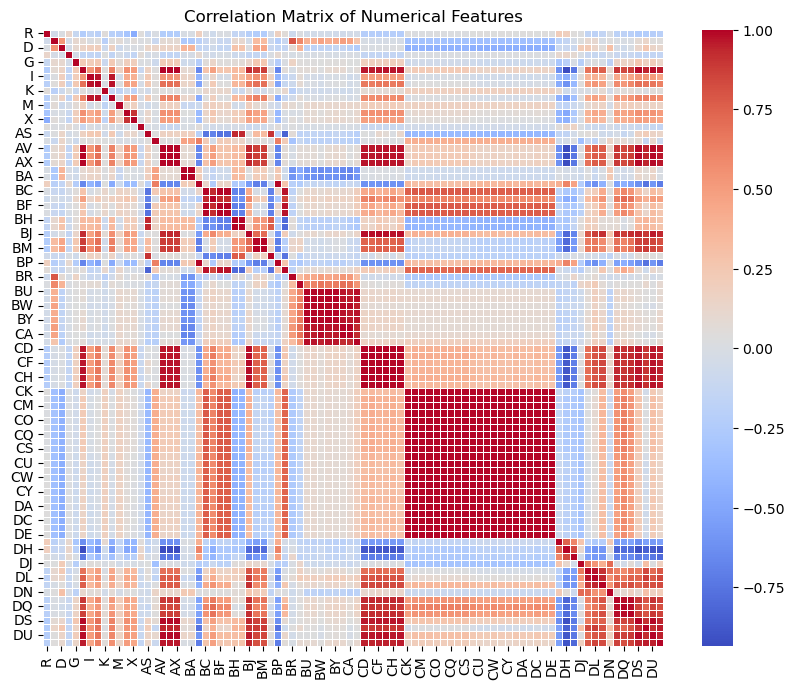

In [6]:
# Preprocess the Data and define the target column
target_column = 'N'
 
# X is the feature matrix, and y is the target vector
X_corr = df1.drop(columns=[target_column])
y_corr = df1[target_column]
 
# Identify categorical columns
categorical_cols = X_corr.select_dtypes(include=['object', 'category']).columns
 
# Encode categorical columns using OrdinalEncoder
encoder = OrdinalEncoder()
X_corr[categorical_cols] = encoder.fit_transform(X_corr[categorical_cols])
 
# Identify numerical columns
numerical_cols = X_corr.select_dtypes(include=['int64', 'float64']).columns
 
# Compute the correlation matrix
corr_matrix = X_corr[numerical_cols].corr()
 
# Plot the heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
#plt.savefig("correlation_matrix.png")
plt.show()

## Correlation of Features with Target (N)

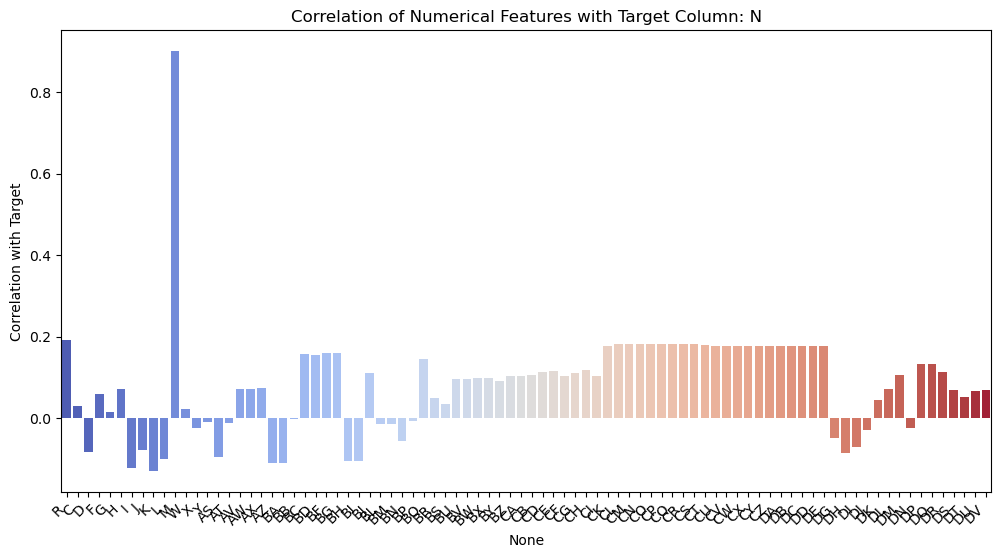

In [7]:
# Compute the correlation between each feature in X and the target column y
correlations = X_corr[numerical_cols].apply(lambda x: x.corr(y_corr))
 
# Convert correlations to a DataFrame for easy plotting
correlation_df = pd.DataFrame(correlations, columns=['Correlation with Target'])
 
# Plot the correlation as a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=correlation_df.index, y='Correlation with Target', data=correlation_df, hue=correlation_df.index, palette='coolwarm', dodge=False, legend=False)
plt.xticks(rotation=45, ha='right')
plt.title(f'Correlation of Numerical Features with Target Column: {target_column}')
#plt.savefig("Correlation of Features with Target 'N'.png")
plt.show()

### Visualizing Feature Relationships with Target Variable (N) Using Subplots

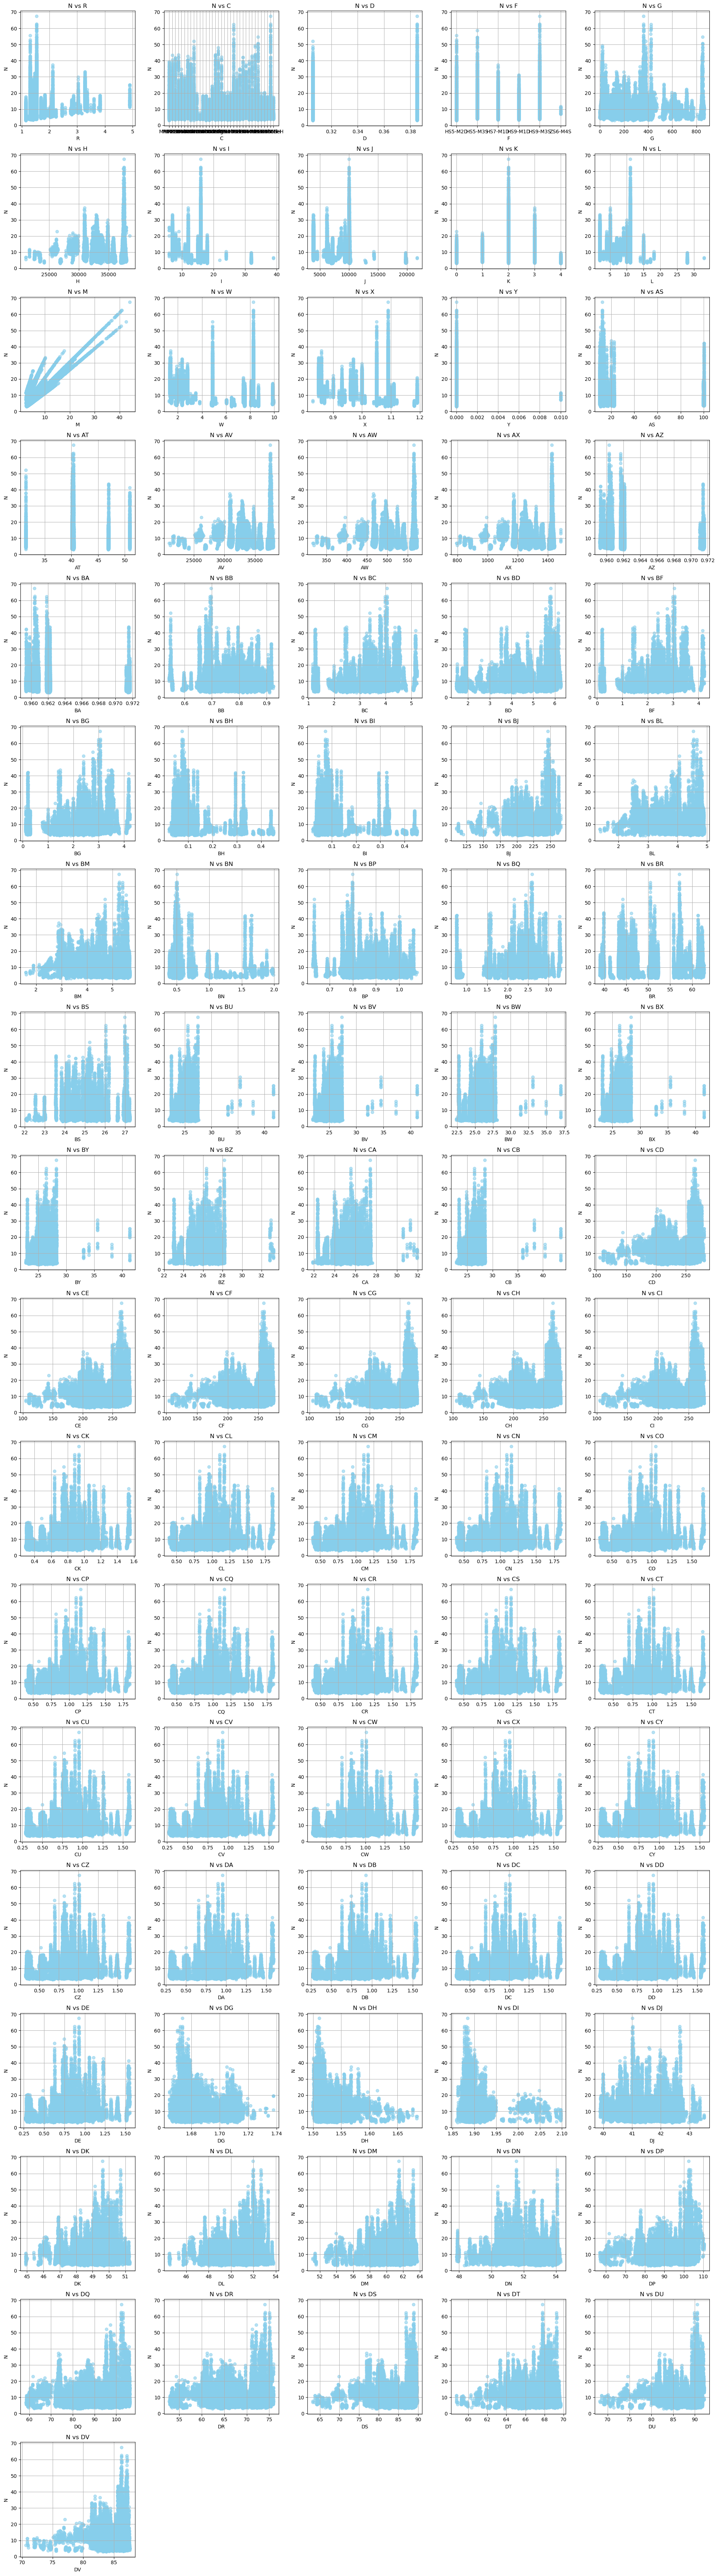

In [8]:
# Define the number of columns per row
cols = 5  
features = [feature for feature in df1.columns if feature != 'N']  # Exclude target 'N'
rows = -(-len(features) // cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # Create subplots

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each feature against N
for i, feature in enumerate(features):
    axes[i].scatter(df1[feature], df1['N'], alpha=0.6, color='skyblue')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('N')
    axes[i].set_title(f'N vs {feature}')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Feature Reduction Using Row-Wise Averages

In [9]:
# Applying Feature Reduction
class FeatureReducer:
    def __init__(self, df, column_lists: list):
        self.df = df
        self.column_lists = column_lists

    def calculate_row_averages(self):
        # Calculate the row-wise mean of the selected columns
        for i, columns in enumerate(self.column_lists):
            col_name = f'Mean{i+1}'
            self.df[col_name] = self.df[columns].mean(axis=1)
        return self.df

# Define column groups for averaging based on correlation analysis, distribution of features, and technical insights
column_lists = [
    ['BU', 'BV', 'BW', 'BX', 'BY', 'BZ', 'CA', 'CB'],
    ['CD', 'CE', 'CF', 'CG', 'CH', 'CI'],
    ['CL', 'CM', 'CN', 'CO', 'CP', 'CQ', 'CR', 'CS', 'CT', 'CU', 'CV', 'CW', 'CX', 'CY', 'CZ', 'DA', 'DB', 'DC', 'DD', 'DE'],
    ['DG', 'DH', 'DI'],
    ['DJ', 'DK', 'DL', 'DM', 'DN'],
    ['DP', 'DQ', 'DR'],
    ['DS', 'DU'],
    ['DT', 'DV']
]

# Apply feature reduction
reducer = FeatureReducer(df, column_lists)
data_with_avg = reducer.calculate_row_averages()

In [10]:
# Grouping and feature encoding
groupby_cols = ['C', 'F', 'I', 'K', 'L']
 
def group_and_filter(df, groupby_cols, min_group_size=5):
    # Initialize an empty list to store groups
    groups = []
    # Group the DataFrame by the specified columns
    df_groups =  df.groupby(groupby_cols)
    # Iterate over each group
    for name, group in df_groups:
        # If the group size is greater than or equal to the minimum size, append it
        if len(group) >= min_group_size:
            groups.append(group)
 
    # Return the list of filtered groups
    return groups

groups= group_and_filter(df, groupby_cols, min_group_size=5)

## Extracting and Encoding Categorical Features

In [11]:
# Encoding feature 'C' by extracting its last character and mapping it to an index, Mapping feature 'F' to unique numerical values
def extract_features(groups):
    all_f_values = pd.concat(groups, axis=0)["F"].unique()
    f_mapping = {value: idx for idx, value in enumerate(all_f_values)}

    for group in groups:
        group["C"] = group["C"].str[-1]
        updown = list(pd.concat(groups, axis=0)["C"].unique())
        group["C"] = group["C"].apply(lambda x: updown.index(x))
        group["F"] = group["F"].map(f_mapping)
        #Drop unwanted columns
        #group.drop(["I", "K"], axis=1, inplace=True)
    return groups

groups = extract_features(groups)

## Preparing Final Dataset for Modeling

In [12]:
# Concatenate groups into a single DataFrame
train_df_conc = pd.concat(groups)

# Separate target and features
target = train_df_conc["N"]
train_df_conc.drop(['N', 'M','R', 'BU', 'BV', 'BW', 'BX', 'BY', 'BZ', 'CA', 'CB',
                    'CD', 'CE', 'CF', 'CG', 'CH', 'CI',
                    'CL', 'CM', 'CN', 'CO', 'CP', 'CQ', 'CR', 'CS', 'CT', 'CU', 'CV', 'CW', 'CX', 'CY', 'CZ', 'DA', 'DB', 'DC', 'DD', 'DE',
                    'DG', 'DH', 'DI',
                    'DJ', 'DK', 'DL', 'DM', 'DN',
                    'DP', 'DQ', 'DR',
                    'DS', 'DU',
                    'DT', 'DV'], axis=1, inplace=True)

##  Model Training and Evaluation

### Computing Sample Weights
- Assign higher weights to rapid changes in the target variable (N).

In [13]:
# Function to compute sample weights
def compute_sample_weights(y):
    diff = np.abs(np.diff(y, prepend=y.iloc[0]))  # Fix indexing issue
    if np.max(diff) > 0:
        weights = 1 + (diff / np.max(diff))  # Normalize and scale
    else:
        weights = np.ones_like(y)
    return weights

### Train-Test Split

In [14]:
# Train-test split (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(train_df_conc, target, test_size=0.2, random_state=42)

### Preparing Data for XGBoost
- Converting training data into DMatrix format, including sample weights.

In [15]:
# Compute sample weights for training data
sample_weights = compute_sample_weights(y_train)

# Convert to DMatrix format for XGBoost (including sample weights)
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
dval = xgb.DMatrix(X_val, label=y_val)

### Hyperparameter Tuning with Grid Search
- Performing a grid search to find the best combination of hyperparameters using 10-fold cross-validation.

In [ ]:
# Define hyperparameter grid (fixed gamma and min_child_weight)
param_grid = {
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [ 0.8, 1.0]
}

# Fixed parameters (removed from loops)
fixed_params = {
    'objective': 'reg:squarederror',
    'gamma': 1,  # Fixed regularization parameter
    'min_child_weight': 5  # Fixed for better generalization
}

# Initialize tracking variables
best_score = float('inf')
best_params = None
best_n_estimators = None

# Grid search over hyperparameters
for max_depth in param_grid['max_depth']:
    for learning_rate in param_grid['learning_rate']:
        for subsample in param_grid['subsample']:
            for colsample_bytree in param_grid['colsample_bytree']:
                
                # Define parameters with fixed values
                params = {
                    **fixed_params,  # Include fixed parameters
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'subsample': subsample,
                    'colsample_bytree': colsample_bytree
                }

                # Perform cross-validation
                cv_results = xgb.cv(
                    params=params,
                    dtrain=dtrain,
                    num_boost_round=500,
                    nfold=10,
                    metrics="rmse",
                    early_stopping_rounds=10,
                    verbose_eval=False
                )

                # Get the best RMSE
                mean_rmse = cv_results['test-rmse-mean'].min()
                if mean_rmse < best_score:
                    best_score = mean_rmse
                    best_params = params
                    best_n_estimators = cv_results.shape[0]

print(f"Best hyperparameters: {best_params}")
print(f"Best RMSE: {best_score:.4f}")
print(f"Best number of estimators (rounds): {best_n_estimators}")

###  Training the Best XGBoost Model and making predictions

In [ ]:
# Train the final model with best hyperparameters
best_xgb_model = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=best_n_estimators
)

# Make predictions
y_train_pred = best_xgb_model.predict(dtrain)
y_val_pred = best_xgb_model.predict(dval)

###  Residual Correction with SVR
- Training an SVR model to predict residuals from XGBoost predictions.
- Adjusting predictions using SVR-based residual correction.

In [ ]:
# Compute residuals
y_train_residuals = y_train - y_train_pred
y_val_residuals = y_val - y_val_pred


# Train SVR on residuals
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train_residuals)

# Predict residuals with SVR
svr_train_residual_pred = svr_model.predict(X_train)
svr_val_residual_pred = svr_model.predict(X_val)

# Final predictions: XGBoost + SVR correction*Correction_direction
correction_direction_train = np.sign(y_train_pred)
correction_direction_val = np.sign(y_val_pred)

final_train_pred = y_train_pred + (svr_train_residual_pred*correction_direction_train)
final_val_pred = y_val_pred + (svr_val_residual_pred*correction_direction_val)

### Model Evaluation

In [ ]:
# Evaluate the model
train_mae = mean_absolute_error(y_train, final_train_pred)
val_mae = mean_absolute_error(y_val, final_val_pred)
train_mse = mean_squared_error(y_train, final_train_pred)
val_mse = mean_squared_error(y_val, final_val_pred)
train_r2 = r2_score(y_train, final_train_pred)
val_r2 = r2_score(y_val, final_val_pred)

# Print results
print(f"Train MAE: {train_mae:.4f}, Train MSE: {train_mse:.4f}, Train R2: {train_r2:.4f}")
print(f"Validation MAE: {val_mae:.4f}, Validation MSE: {val_mse:.4f}, Validation R2: {val_r2:.4f}")

In [ ]:
# Plot Actual vs Predicted Target Values
plt.figure(figsize=(10, 6))
plt.plot(y_val.values[:100], label="Actual", color="blue", alpha=0.7)
plt.plot(y_val_pred[:100], label="Predicted", color="orange", alpha=0.7)
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs Predicted Target Values (Validation Set)")
plt.legend()
plt.grid()
plt.show()

## Processing Test Data and Making Predictions

In [ ]:
# Load the holdout test dataset
test_df = pd.read_pickle("Turbo_Charger_Challenge_Features.pkl")
test_df.dropna(inplace=True)

### Feature Engineering on Test Data

In [ ]:
# Instantiate the FeatureReducer class with the DataFrame and selected columns
reducer = FeatureReducer(test_df, column_lists)

# Calculate the row-wise averages and add the new columns
test_df = reducer.calculate_row_averages()

In [ ]:
# Group the data and extract features
groups= group_and_filter(test_df, groupby_cols, min_group_size=0)

# Apply the feature extraction function
groups = extract_features(groups)

# Concatenate the processed groups
test_df = pd.concat(groups)

### Aligning Test Data with Training Features

In [ ]:
# Assuming X_train is a DataFrame
training_features = X_train.columns  

# Align test_df with training feature set
test_df = test_df.reindex(columns=training_features, fill_value=0)

### Making Predictions with XGBoost and SVR Correction
- Using the trained XGBoost model to generate predictions.
- Applying SVR residual correction if the SVR model is available.

In [ ]:
# Make predictions using the trained model
predictions = best_xgb_model.predict(xgb.DMatrix(test_df))

# Predict residuals using a trained SVR model
try:
    svr_residuals = svr_model.predict(test_df)  # Ensure SVR model is trained
    correction_direction = np.sign(predictions)
    final_predictions = predictions + (svr_residuals*correction_direction)  # Combine both predictions
    print("SVR correction applied.")
except NameError:
    final_predictions = xgb_predictions  # Use only XGBoost predictions
    print("No SVR model detected, using only XGBoost predictions.")

### Saving Predictions and Visualizing Prediction Distribution

In [ ]:
# Save predictions
test_df['N'] = final_predictions
test_df.to_csv("Predictions.csv", index=False)
print("Predictions saved to 'Predictions.csv'")

# Plot the distribution of predictions
plt.figure(figsize=(8, 5))
plt.hist(final_predictions, bins=30, color="skyblue", edgecolor="black", alpha=0.7)
plt.axvline(np.mean(final_predictions), color='red', linestyle='dashed', linewidth=2, label="Mean Prediction")
plt.xlabel("Predicted Values for N")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Target (N)")
plt.legend()
plt.grid()
plt.show()

## Model Evaluation Using Holdout Data (Turbo_Charger_Holdout.pkl)

In [ ]:
# Use test_df directly instead of reading from Predictions.csv
predictions_df = test_df.copy()  # Ensure predictions_df holds the same data

# Load Turbo_Charger_Holdout.pkl
with open("Turbo_Charger_Holdout.pkl", "rb") as f:
    holdout_data = pickle.load(f)

# Ensure the holdout data is a DataFrame
if isinstance(holdout_data, dict):
    holdout_df = pd.DataFrame(holdout_data)
elif isinstance(holdout_data, pd.DataFrame):
    holdout_df = holdout_data
else:
    raise ValueError("Unsupported data format in Turbo_Charger_Holdout.pkl")

# Extract feature N for evaluation
if "N" not in predictions_df.columns or "N" not in holdout_df.columns:
    raise ValueError("Feature 'N' not found in one or both datasets")

y_true = holdout_df["N"].values
y_pred = predictions_df["N"].values

# Compute Mean Squared Error
mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error: {mse}")